# Финальный проект: телекоммуникации

## Описание проекта

**Бизнес-задача:** Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. 

**Задача проекта:** Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор, т.е. стоит задача бинарной классификации.

Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Нужно обучить на этих данных модель для прогноза оттока клиентов.

**Важно:** клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

**Что за услуги есть у оператора**

*Основные услуги*
- Стационарная телефонная связь. Телефон можно подключить к нескольким линиям одновременно
- Интернет. Или через DSL, или через оптоволокно

*Дополнительные услуги*
- Безопасность в сети: антивирус и блокировка опасных сайтов
- Выделенная поддержка клиента
- Облачное хранилище
- Стриминг

## Описание данных

Есть несколько файлов, которые нам нужно будет объединить:
    
1. **contract_new.csv:** сведения о договоре

- customerID — идентификатор абонента;
- BeginDate — дата начала действия договора;
- EndDate — дата окончания действия договора, **основа для будущего целевого признака**;
- Type — тип оплаты: раз в год-два или ежемесячно;
- PaperlessBilling — электронный расчётный лист;
- PaymentMethod — тип платежа;
- MonthlyCharges — расходы за месяц;
- TotalCharges — общие расходы абонента.

2. **personal_new.csv:** личные данные клиента

- customerID — идентификатор пользователя;
- gender — пол;
- SeniorCitizen — является ли абонент пенсионером;
- Partner — есть ли у абонента супруг или супруга;
- Dependents — есть ли у абонента дети.

3. **internet_new.csv:** информация об интернет-услугах

- customerID — идентификатор пользователя;
- InternetService — тип подключения;
- OnlineSecurity — блокировка опасных сайтов;
- OnlineBackup — облачное хранилище файлов для резервного копирования данных;
- DeviceProtection — антивирус;
- TechSupport — выделенная линия технической поддержки;
- StreamingTV — стриминговое телевидение;
- StreamingMovies — каталог фильмов.

4. **phone_new.csv:** сведения об услугах телефонии

- customerID — идентификатор пользователя;
- MultipleLines — подключение телефона к нескольким линиям одновременно.

Во всех файлах столбец customerID содержит код клиента. Информация о договорах актуальна на 1 февраля 2020 года.

## План работы

**Шаг 1. Загрузка данных**

Загрузим нужные библиотеки, зафиксируем параметры. Загрузим данные, выполним их первичный осмотр.

**Шаг 2. Исследовательский анализ**

Выполним исследовательский анализ  датафреймов, сделаем предварительные выводы об имеющихся признаках: понадобятся ли они для обучения моделей.

**Шаг 3. Объединение данных**

Объединим выбранные признаки в один датафрейм по ключу. При необходимости создадим новые признаки.

**Шаг 4. Исследовательский анализ и предобработка данных объединённого датафрейма**

Выполним исследовательский анализ объединённого датафрейма, визуализируем распределения признаков и при необходимости выполним предобработку. Проведем корреляционный анализ.

**Шаг 5. Подготовка данных**

Выполним подготовку данных для обучения модели. Разделите данные на две выборки, при масштабировании и кодировании учитывайте особенности данных и моделей.

**Шаг 6. Обучение моделей машинного обучения**

Обучим как минимум две модели. Хотя бы для одной из них подберем как минимум два гиперпараметра.

**Шаг 7. Выбор лучшей модели**

Выберем лучшую модель и проверим её качество на тестовой выборке.

**Шаг 8. Общий вывод и рекомендации заказчику**

Сделаем общий вывод о проделанной работе: опишем основные этапы работы, полученные результаты и дадим рекомендации для бизнеса.

## Шаг 1. Загрузка данных

In [1]:
TEST_SIZE = 0.25
RANDOM_STATE = 20924

import pandas as pd
import os
from datetime import datetime
import requests
import numpy as np
import matplotlib.pyplot as plt
from termcolor import colored
import seaborn as sns

import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from sklearn.metrics import make_scorer

from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler,
    LabelEncoder
)

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import (train_test_split, 
                                     cross_val_score, GridSearchCV, 
                                     KFold, cross_val_predict)
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.dummy import DummyClassifier
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.compose import ColumnTransformer

In [3]:
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    f1_score, 
    roc_auc_score, 
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    classification_report,
    roc_curve
)

from sklearn.exceptions import ConvergenceWarning
import warnings
from tqdm import tqdm

In [4]:
pd.options.mode.chained_assignment = None
from urllib.request import urlretrieve
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [5]:
# Функция для загрузки и чтения датафреймов

def load_dataframe(url, local_path):
    if os.path.exists(local_path):
        try:
            df = pd.read_csv(local_path, parse_dates=True)
            print(f'Файл загружен локально: {local_path}')
        except Exception as e:
            print(f'Ошибка при чтении локального файла {local_path}:', e)
            df = None
    else:
        try:
            urlretrieve(url, local_path)
            df = pd.read_csv(local_path, parse_dates=True)
            print(f'Файл загружен с URL и сохранен локально: {local_path}')
        except Exception as e:
            print(f'Ошибка при загрузке файла с URL {url}:', e)
            df = None
    return df

In [6]:
#функция для вывода первичной информации

def quick_info(df_list):
    for df in df_list:
        print(colored('Общая информация:', 'red', attrs=['bold']))
        print(df.info())
        print(colored('Статистика по числовым данным:', 'red', attrs=['bold']))
        print(df.describe())
        print(colored('Дубликаты:', 'red', attrs=['bold']))
        print(df.duplicated().sum())

In [7]:
## функция для оценки на неявные дубликаты

def print_unique_values(df, columns):
    for column in columns:
        if column in df.columns:
            print(colored(f"Уникальные значения столбца '{column}':", 'red', attrs=['bold']))
            print(df[column].sort_values().unique())
        else:
            print(colored(f"Столбец '{column}' отсутствует в датафрейме", 'yellow'))

In [8]:
#функция для построения гистограммы и ящика с усами для каждого количественного признака

def histbox(df, exclude_cols=[], 
            bins=80, figsize=(15, 5), 
            title_fontsize=14, axis_fontsize=12):
    
    numeric_features = df.drop(
        columns=exclude_cols).select_dtypes(include=[np.number]).columns.tolist()

    num_rows = len(numeric_features)
    num_cols = 2

    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    
    for i, feature in enumerate(numeric_features):
        if df[feature].nunique() > 10:
            sns.histplot(df[feature], bins=bins, ax=axes[i, 0])
        else:
            sns.countplot(x=df[feature], ax=axes[i, 0], data=df)
        axes[i, 0].set_title(f'Гистограмма для \n{feature}', fontsize=title_fontsize)
        axes[i, 0].tick_params(axis='both', labelsize=axis_fontsize)

        sns.boxplot(x=df[feature], ax=axes[i, 1], data=df)
        axes[i, 1].set_title(f'Боксплот для \n{feature}', fontsize=title_fontsize)
        axes[i, 1].tick_params(axis='both', labelsize=axis_fontsize)

    plt.tight_layout()
    plt.show()

In [9]:
#функция для столбчатой и круговой диаграмм для категориальных признаков

def catplot(df, exclude_cols=[], figsize=(15, 50), 
            title_fontsize=12, axis_fontsize=8, pie_fontsize=8):

    cat_features = df.drop(columns=exclude_cols).select_dtypes(include='object').columns

    num_features = len(cat_features)
    fig, axes = plt.subplots(num_features, 2, figsize=figsize)

    for i, feature in enumerate(cat_features):
        counts = df[feature].value_counts()
        if len(counts) > 4:
            counts = counts.head(10)
            counts['Другие'] = df[feature].shape[0] - counts.sum()

        sns.barplot(x=counts.index, y=counts.values, ax=axes[i, 0])
        axes[i, 0].set_title(f'Столбчатая диаграмма для \n{feature}', 
                             fontsize=title_fontsize)
        axes[i, 0].set_xlabel('')
        axes[i, 0].set_ylabel('Количество', fontsize=axis_fontsize)
        axes[i, 0].tick_params(axis='both', labelsize=axis_fontsize)
        axes[i, 0].set_xticklabels(axes[i, 0].get_xticklabels(), rotation=30)

        wedges, texts, autotexts = axes[i, 1].pie(
            counts,
            labels=counts.index,
            autopct='%1.1f%%',
            startangle=90,
            explode=[0.1] * len(counts),
            pctdistance=0.85,
            labeldistance=1.2
        )

        centre_circle = plt.Circle((0, 0), 0.50, color='white', fc='white')
        axes[i, 1].add_artist(centre_circle)

        axes[i, 1].set_title(f'Круговая диаграмма для \n{feature}', fontsize=title_fontsize)
        axes[i, 1].set_ylabel('')
        axes[i, 1].tick_params(axis='both', labelsize=axis_fontsize)

        for text in autotexts:
            text.set_color('black')
            text.set_fontsize(pie_fontsize)
        for text in texts:
            text.set_fontsize(pie_fontsize)
    
    plt.subplots_adjust(hspace=0.7, wspace=0.4)
    plt.show()

In [10]:
#функция для подсчета метрик модели

def evaluate_model(clf, X_train, y_train, X_test, y_test):
    roc_auc_cv = cross_val_score(clf, X_train, y_train, scoring='roc_auc').mean()
    y_test_proba = clf.predict_proba(X_test)[:, 1]
    
    acc_test = accuracy_score(y_test, clf.predict(X_test))
    f1_test = f1_score(y_test, clf.predict(X_test))
    roc_auc_test = roc_auc_score(y_test, y_test_proba)
    
    return roc_auc_cv, roc_auc_test, acc_test, f1_test

Для начала загрузим четыре наших датафрейма с помощью функции load_dataframe(), чтобы не прописывать конструкцию try-except по каждому датафрейму отдельно. В функции также есть отладочные сообщения, чтобы понимать, откуда загружен датафрейм или где произошла ошибка.

In [11]:
dfs = [
    {
        'name': 'contract_new',
        'url': 'https://code.s3.yandex.net/datasets/contract_new.csv',
        'local_path': '/Users/macbookpro/Downloads/contract_new.csv'
    },
    {
        'name': 'personal_new',
        'url': 'https://code.s3.yandex.net/datasets/personal_new.csv',
        'local_path': '/Users/macbookpro/Downloads/personal_new.csv'
    },
    {
        'name': 'internet_new',
        'url': 'https://code.s3.yandex.net/datasets/internet_new.csv',
        'local_path': '/Users/macbookpro/Downloads/internet_new.csv'
    },
    {
        'name': 'phone_new',
        'url': 'https://code.s3.yandex.net/datasets/phone_new.csv',
        'local_path': '/Users/macbookpro/Downloads/phone_new.csv'
    }
]

In [12]:
dataframes = {}

for file in dfs:
    df = load_dataframe(file['url'], file['local_path'])
    if df is not None:
        dataframes[file['name']] = df

contract_df = dataframes.get('contract_new')
personal_df = dataframes.get('personal_new')
internet_df = dataframes.get('internet_new')
phone_df = dataframes.get('phone_new')

Файл загружен локально: /Users/macbookpro/Downloads/contract_new.csv
Файл загружен локально: /Users/macbookpro/Downloads/personal_new.csv
Файл загружен локально: /Users/macbookpro/Downloads/internet_new.csv
Файл загружен локально: /Users/macbookpro/Downloads/phone_new.csv


Посмотрим на первые пять строк каждого из датафреймов в отдельности:

In [13]:
contract_df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


Видим, что данные по договорам загрузились корректно.  

In [14]:
personal_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Все гуд, загрузился датафрейм по персональным данным.

In [15]:
internet_df.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Тоже нормальная ситуация, ничего не потерялось из признаков в датафрейме с данным по интернет-услугам, id тоже на месте.

In [16]:
phone_df.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Все хорошо! Изучим чуть тщательнее каждый датафрейм с помощью функции quick_info()

In [17]:
all_df = [contract_df, personal_df, internet_df, phone_df]

quick_info(all_df)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None
Статистика по числовым данным:
       MonthlyCharges
count     7043.000000
mean        64.761692
std         30.090047
min         18.250000
25%         35.500000
50%         70.350000
75%         89.850000
max        118.750000
Дубликаты:
0
Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns 

Посмотрим еще на неявные дубликаты с помощью нашей функции print_unique_values(). Колонки из 2, 3 и 4 датафрейма забирать не будем, тк по ним видно было в выводе предыдущей функции, что нет неявных дубликатов или пропусков.

In [18]:
columns_to_check = ['EndDate', 'Type', 'PaperlessBilling', 
                    'PaymentMethod', 'MonthlyCharges', 'TotalCharges',
                   ]

print_unique_values(contract_df, columns_to_check)

Уникальные значения столбца 'EndDate':
['2014-06-01' '2014-09-01' '2014-10-01' '2014-11-01' '2014-12-01'
 '2015-01-01' '2015-02-01' '2015-03-01' '2015-04-01' '2015-05-01'
 '2015-06-01' '2015-07-01' '2015-08-01' '2015-09-01' '2015-10-01'
 '2015-11-01' '2015-12-01' '2016-01-01' '2016-02-01' '2016-03-01'
 '2016-04-01' '2016-05-01' '2016-06-01' '2016-07-01' '2016-08-01'
 '2016-09-01' '2016-10-01' '2016-11-01' '2016-12-01' '2017-01-01'
 '2017-02-01' '2017-03-01' '2017-04-01' '2017-05-01' '2017-06-01'
 '2017-07-01' '2017-08-01' '2017-09-01' '2017-10-01' '2017-11-01'
 '2017-12-01' '2018-01-01' '2018-02-01' '2018-03-01' '2018-04-01'
 '2018-05-01' '2018-06-01' '2018-07-01' '2018-08-01' '2018-09-01'
 '2018-10-01' '2018-11-01' '2018-12-01' '2019-01-01' '2019-02-01'
 '2019-03-01' '2019-04-01' '2019-05-01' '2019-06-01' '2019-07-01'
 '2019-08-01' '2019-09-01' '2019-10-01' '2019-11-01' '2019-12-01'
 '2020-01-01' 'No']
Уникальные значения столбца 'Type':
['Month-to-month' 'One year' 'Two year']
Уникал

Видим, что в значении 'TotalCharges' есть строчки с нулевым значением. Посмотрим на них:

In [19]:
print(contract_df[contract_df['TotalCharges'] == ' '])

      customerID   BeginDate EndDate      Type PaperlessBilling  \
488   4472-LVYGI  2020-02-01      No  Two year              Yes   
753   3115-CZMZD  2020-02-01      No  Two year               No   
936   5709-LVOEQ  2020-02-01      No  Two year               No   
1082  4367-NUYAO  2020-02-01      No  Two year               No   
1340  1371-DWPAZ  2020-02-01      No  Two year               No   
3331  7644-OMVMY  2020-02-01      No  Two year               No   
3826  3213-VVOLG  2020-02-01      No  Two year               No   
4380  2520-SGTTA  2020-02-01      No  Two year               No   
5218  2923-ARZLG  2020-02-01      No  One year              Yes   
6670  4075-WKNIU  2020-02-01      No  Two year               No   
6754  2775-SEFEE  2020-02-01      No  Two year              Yes   

                  PaymentMethod  MonthlyCharges TotalCharges  
488   Bank transfer (automatic)           52.55               
753                Mailed check           20.25               
936   

Что видим:
    
**contract_df:**

- Всего 8 столбцов и 7043 строчки
- BeginDate и EndDate (частично) можно перевести в datetime64, TotalCharges нужно сделать float64
- В 11 строчках нулевое значение TotalCharges.
- Сильный разброс в расходах за месяц, возможно, есть аномалии
- Явных дубликатов и пропусков нет

**personal_df:**

- Всего 5 столбцов и 7043 строчки
- Partner и Dependents можно перевести в числа: 1 True и 0 False
- Пенсионеров в датафрейме не особенно много
- Явных дубликатов и пропусков нет

**internet_df:**

- Всего 8 столбцов и 5517 строчек по клиентам с интернет-услугами
- Все категориальные признаки можно будет сделать числовыми
- Явных дубликатов и пропусков нет

**phone_df:**

- Всего 2 столбца и 6360 строчек по клиентам с услугами телефонии
- Категориальный признак можно будет сделать числовым
- Явных и неявных дубликатов и пропусков нет

### Выводы:

- Успешно загрузили четыре датафрейма;
- Нашли 11 строчек в contract_df с нулевым значением TotalCharges, возможно, придется обрабатывать или удалять
- Изучили, какие признаки можно будет перевести в другой тип данных или оцифровать
- Явных дубликатов и пропусков пока не обнаружили

## Шаг 2. Исследовательский анализ

Сперва поработаем с датафреймом contract_df. До анализа решу проблему с 11 пустыми строками в TotalCharges: заполню их медианными значениями, тк строк не очень много и хочется их сохранить. Переведу столлбец в float64.

In [20]:
def clean_and_convert(column):
    column = column.str.replace(' ', '')
    return pd.to_numeric(column, errors='coerce')

contract_df['TotalCharges'] = clean_and_convert(contract_df['TotalCharges'])

median_value = contract_df['TotalCharges'].median()
contract_df['TotalCharges'].fillna(median_value, inplace=True)

contract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


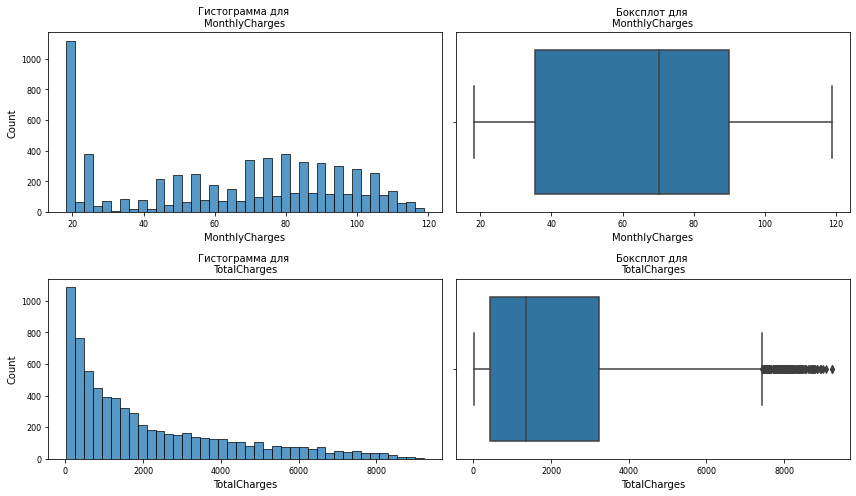

In [21]:
histbox(
    contract_df, 
    exclude_cols=['customerID'], 
    bins=40, figsize=(12, 7), 
    title_fontsize=10, 
    axis_fontsize=8
)

**Предварительные выводы:**

- MonthlyCharges: ненормальное распределение со сдвигом влево, аномалий скорее всего нет. Большинство клиентов платит от 40 до 90 в месяц.
- TotalCharges: ненормальное распределение со сдвигом влево, довольно большой разброс по тратам. Аномалий как таковых нет: можно допустить, что клиенты с долгой историей заплатили суммарно более 7000.

Перейдем к категориальным признакам:

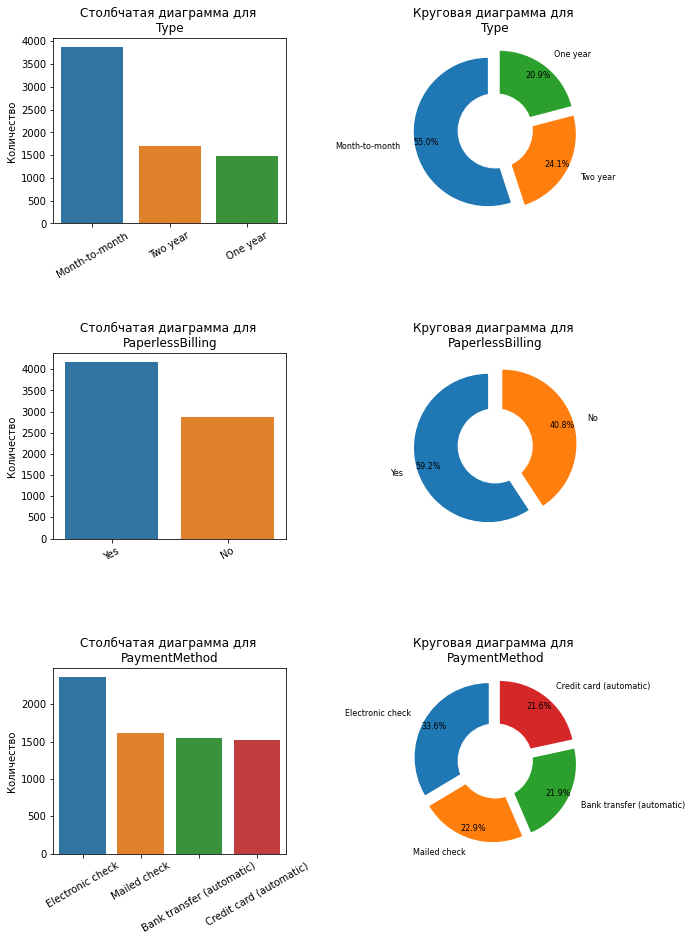

In [22]:
catplot(contract_df, 
        exclude_cols=['customerID', 'BeginDate', 'EndDate'], 
        figsize=(10, 15), 
        title_fontsize=12,
        axis_fontsize=10
)

**Предварительные выводы:**
    
- Половина клиентов из набора ежемесячно оплачивает договор
- Большинство предпочитает электронный расчетный лист
- По методу оплат лидирует электронный чек.

Отдельно посмотрим на EndDate, наш целевой признак:

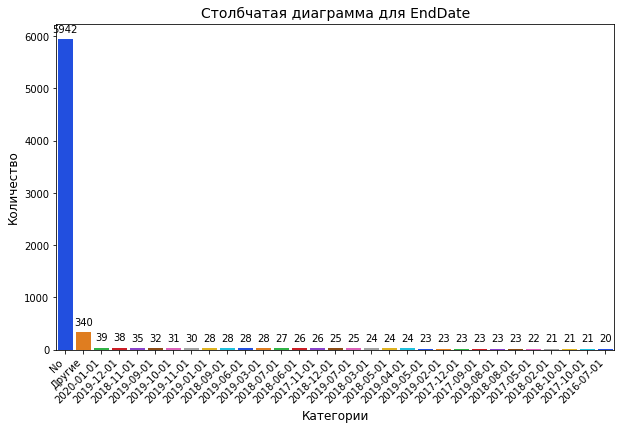

In [23]:
top_n = 30
counts = contract_df['EndDate'].value_counts()

counts_top_n = counts.head(top_n)
counts_other = counts.iloc[top_n:].sum()

if counts_other > 0:
    counts_top_n['Другие'] = counts_other
    
counts_top_n = counts_top_n.sort_values(ascending=False)
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=counts_top_n.index, y=counts_top_n.values, palette='bright')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points', 
                fontsize=10)
    
plt.title(f'Столбчатая диаграмма для EndDate', fontsize=14)
plt.xlabel('Категории', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.xticks(rotation=45, ha='right')

plt.show()

Построим также распределение для клиентов, которые ушли:

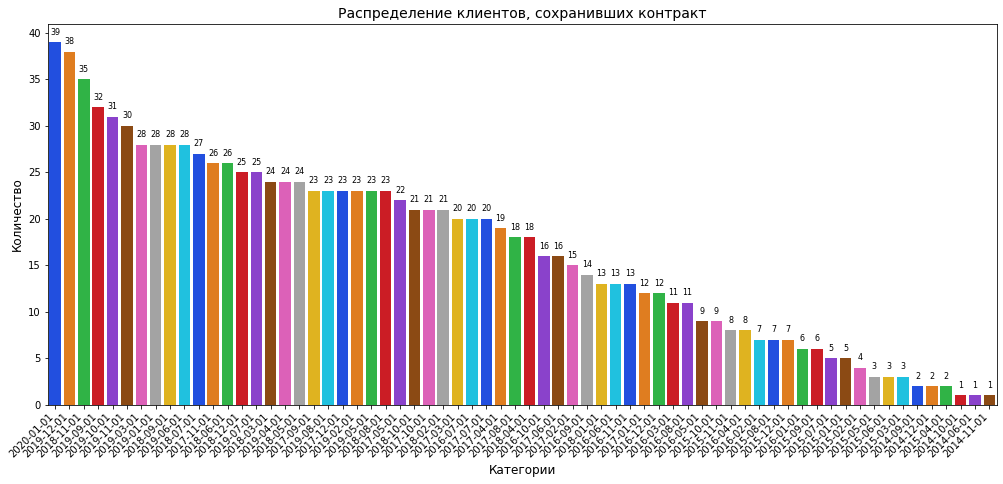

In [24]:
filtered_df = contract_df[contract_df['EndDate'] != 'No']

counts_clients = filtered_df['EndDate'].value_counts()
counts_sorted = counts_clients.sort_values(ascending=False)

plt.figure(figsize=(17, 7))
ax = sns.barplot(x=counts_sorted.index, y=counts_sorted.values, palette='bright')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points', 
                fontsize=8)

plt.title(f'Распределение клиентов, сохранивших контракт', fontsize=14)
plt.xlabel('Категории', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.xticks(rotation=45, ha='right')

plt.show()

**Предварительные выводы:**

- Большая часть клиентов продлевает контракт (5942 строчки)
- Большинство клиентов из тех, кто не продлился, завершили контракт 2020-01-01: возможно, из-за годового повышения цен
- Среди других частотных дат по расторжению контракта: 2019-12-01, 2018-11-01, 2019-09-01
- Классы несбалансированы: тех, кто не расторг контракт, больше: 5942 против примерно 1500 тысяч тех, кто оборвал.
- Видим, что большая часть клиентов уходит или в начале года, или в конце: январь, декабрь, ноябрь.

Изучим далее персональные данные клиентов:

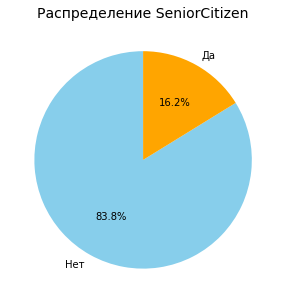

In [25]:
counts = personal_df['SeniorCitizen'].value_counts()

plt.figure(figsize=(5, 5))
counts.plot(kind='pie', labels=['Нет', 'Да'], autopct='%1.1f%%', startangle=90, colors=['skyblue', 'orange'])

plt.title('Распределение SeniorCitizen', fontsize=14)
plt.ylabel('')

plt.show()

**Предварительные выводы:**
  
- Людей старшего возраста среди клиентов гораздо меньше, чем других возрастных категорий: 16,2% к 83,8%.

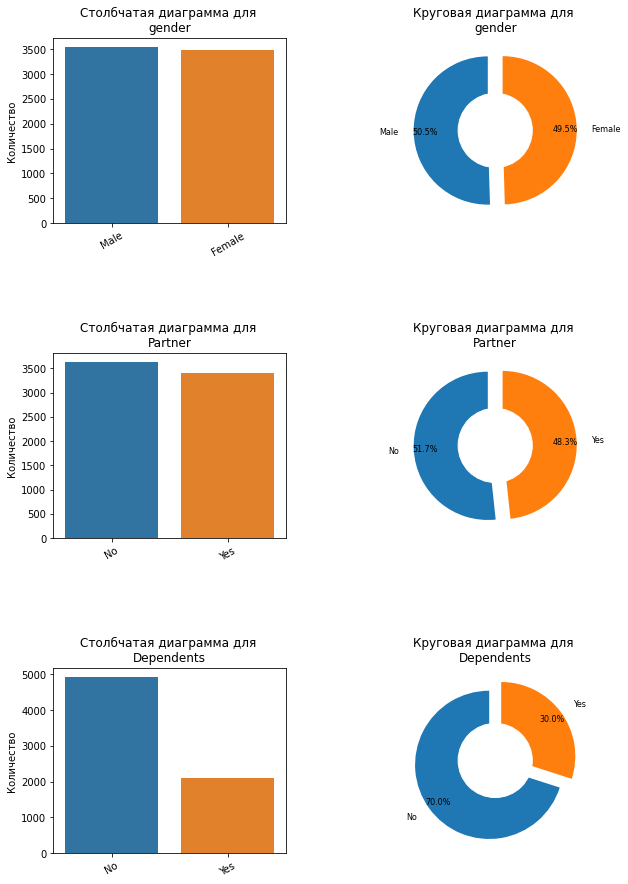

In [26]:
catplot(personal_df, 
        exclude_cols=['customerID'], 
        figsize=(10, 15), 
        title_fontsize=12,
        axis_fontsize=10
)

**Предварительные выводы:**
  
- По полу клиентов примерно поровну
- Клиентов с супругом(-ой) и без них (нее) тоже поровну
- Клиентов без детей больше, чем с детьми: 70% против 30%.

Посмотрим на информацию об интернет-услугах: 

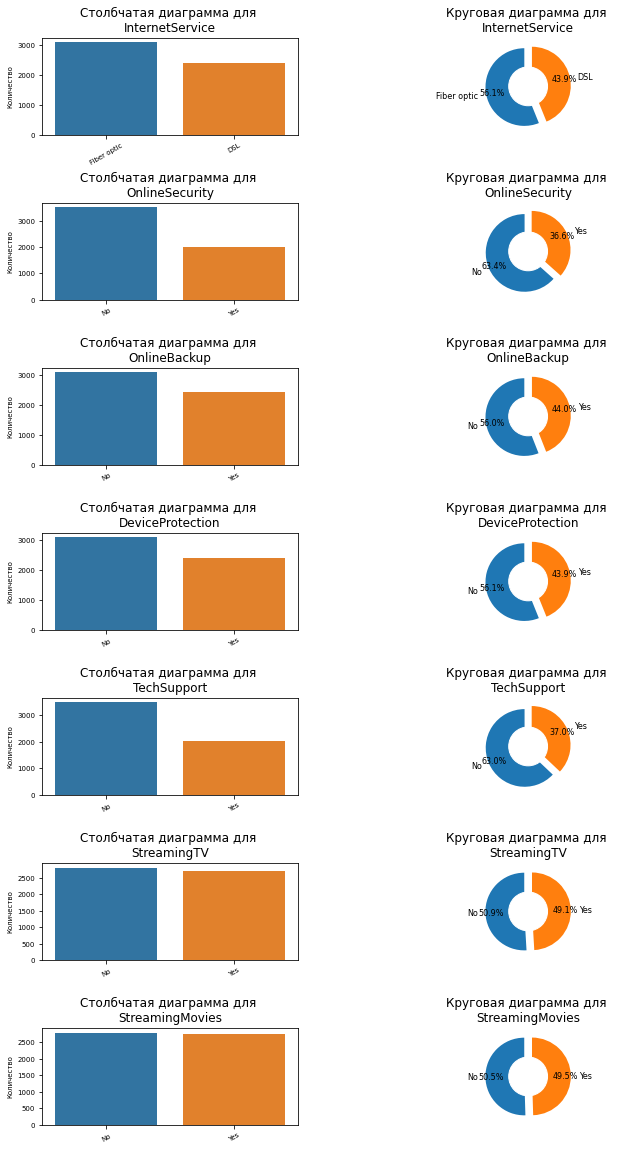

In [27]:
catplot(internet_df, 
        exclude_cols=['customerID'], 
        figsize=(11, 20), 
        title_fontsize=12,
        axis_fontsize=7
)

**Предварительные выводы:**
  
- Немного больше клиентов выбирают оптоволокно, не DSL: 56.1%
- Услуги по блокировке опасных сайтов оформляют чуть больше трети клиентов (36.6%)
- Облачное хранилище оформляют 44% клиентов
- Антивирус устанавливают примерно столько же, 43.9%
- Выделенную поддержку берут 37% клиентов
- Стриминговое ТВ и каталог фильмов оформляют примерно по половине клиентов.

Посмотрим на распределение по услугам телефонии:

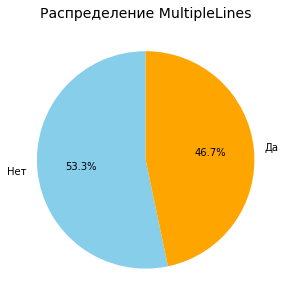

In [28]:
counts = phone_df['MultipleLines'].value_counts()

plt.figure(figsize=(5, 5))
counts.plot(kind='pie', labels=['Нет', 'Да'], autopct='%1.1f%%', startangle=90, colors=['skyblue', 'orange'])

plt.title('Распределение MultipleLines', fontsize=14)
plt.ylabel('')

plt.show()

**Предварительные выводы:**

- Подключение телефона к нескольким линиям одновременно оформляют 46.7% клиентов

### Выводы:

- До анализа решили проблему с 11 пустыми строками в TotalCharges: заполнили их медианными значениями, тк строк не очень много

**contract_df:**

- EndDate: большая часть клиентов продлевает контракт (5942 строчки). Большинство клиентов из тех, кто не продлился, завершили контракт 2020-01-01: возможно, из-за годового повышения цен
- MonthlyCharges: ненормальное распределение со сдвигом влево, аномалий скорее всего нет. Большинство клиентов платит от 40 до 90 в месяц.
- TotalCharges: ненормальное распределение со сдвигом влево, довольно большой разброс по тратам. Аномалий как таковых нет: можно допустить, что клиенты с долгой историей заплатили суммарно более 7000.
- Половина клиентов из набора ежемесячно оплачивает договор
- Большинство предпочитает электронный расчетный лист
- По методу оплат лидирует электронный чек.

**personal_df:**

- Людей старшего возраста среди клиентов гораздо меньше, чем других возрастных категорий
- По полу клиентов примерно поровну
- Клиентов c супругом(-ой) и без них (нее) тоже поровну
- Клиентов без детей больше, чем с детьми: 70% против 30%.

**internet_df:**

- Немного больше клиентов выбирают оптоволокно, не DSL: 56.1%
- Услуги по блокировке опасных сайтов оформляют чуть больше трети клиентов (36.6%)
- Облачное хранилище оформляют 44% клиентов
- Антивирус устанавливают примерно столько же, 43.9%
- Выделенную поддержку берут 37% клиентов
- Стриминговое ТВ и каталог фильмов оформляют примерно по половине клиентов.

**phone_df:**

- Подключение телефона к нескольким линиям одновременно оформляют 46.7% клиентов

По поводу признаков, которые могут нам понадобиться для модели:
- Предварительно кажется, что пригодиться могут затраты на договор. Есть сомнения по деталям договора и доп услугам.

## Шаг 3-4. Объединение данных и исследовательский анализ

Объединим все четыре датафрейма с помощью ключа customerID методом merge(). На этом этапе сносить признаки пока не будем, сделаем это после корреляционного анализа, если понадобится.

Как будет строиться процесс объединения? Сперва соединим contract_df с personal_df с параметром how='inner'. Далее объединим общий датафрейм с internet_df и phone_df с параметром how='left'. Так мы сохраним все строчки из основных датафреймов. Там, где будут пропуски, будут NaN: их заменим пока на No.

In [29]:
df = pd.merge(contract_df, personal_df, on='customerID', how='inner')
df = pd.merge(df, internet_df, on='customerID', how='left')
df = pd.merge(df, phone_df, on='customerID', how='left')

df.fillna('No', inplace=True)

df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   7043 non-null   object 
 13  OnlineSecurity    7043 non-null   object 
 14  OnlineBackup      7043 non-null   object 
 15  DeviceProtection  7043 non-null   object 
 16  TechSupport       7043 non-null   object 


Проверим, уникальные ли customerID:

In [31]:
df['customerID'].is_unique

True

Успех! Создадем еще целевой признак, ended, на основе EndDays. Он будет означать, отказался клиент от услуг или нет. Если значение в столбце EndDate равно "No", то значит клиент не ушел и целевой признак равен 0. Если дата ухода есть, то целевой признак равен 1.

In [32]:
df['ended'] = (df['EndDate'] != 'No').astype(int)
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,ended
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,No,DSL,No,Yes,No,No,No,No,No,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,No,0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,No,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,...,No,DSL,Yes,No,Yes,Yes,No,No,No,0
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,...,No,Fiber optic,No,No,No,No,No,No,No,0


Снова проведем исследовательский анализ уже объединенного датафрейма

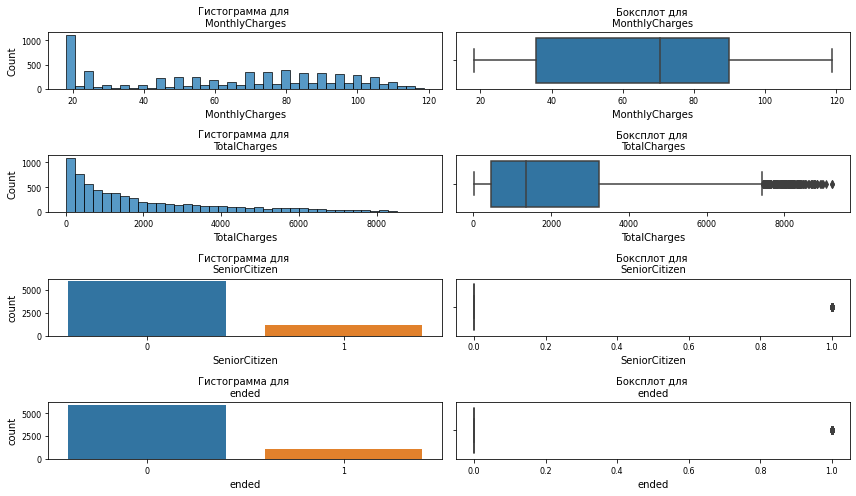

In [33]:
histbox(
    df, 
    exclude_cols=['customerID', 'BeginDate', 'EndDate'], 
    bins=40, figsize=(12, 7), 
    title_fontsize=10, 
    axis_fontsize=8
)

**Предварительные выводы:**
    
- Эти параметры особенно не изменились после объединения, тк они были для всех клиентов.
- Новый признак ended показывает, что классы не сбалансированы. Гораздо больше тех, кто остался с компанией.

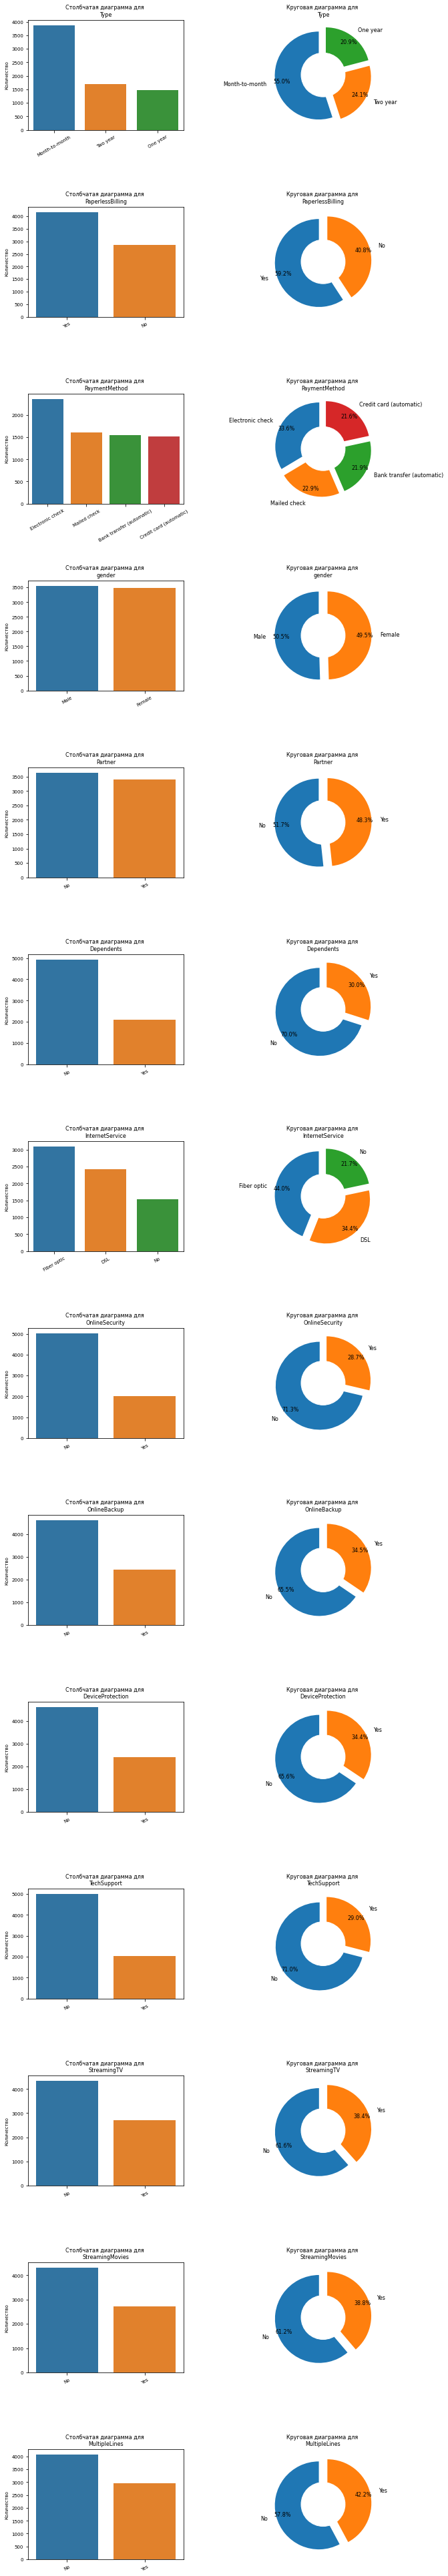

In [34]:
catplot(df, 
        exclude_cols=['customerID', 'EndDate', 'BeginDate'], 
        figsize=(10, 70), 
        title_fontsize=8,
        axis_fontsize=7
)

**Предварительные выводы:**
    
- Видим, что поменялись по распределению признаки, связанные с интернет-услугами и телефонией. Этого следовало ожидать, тк мы объединили датафреймы и появились клиенты, которые не пользуются или интернет-услугами, или телефонией.

Посмотрим также на распределения признаков для ушедших и сохранившихся клиентов: 

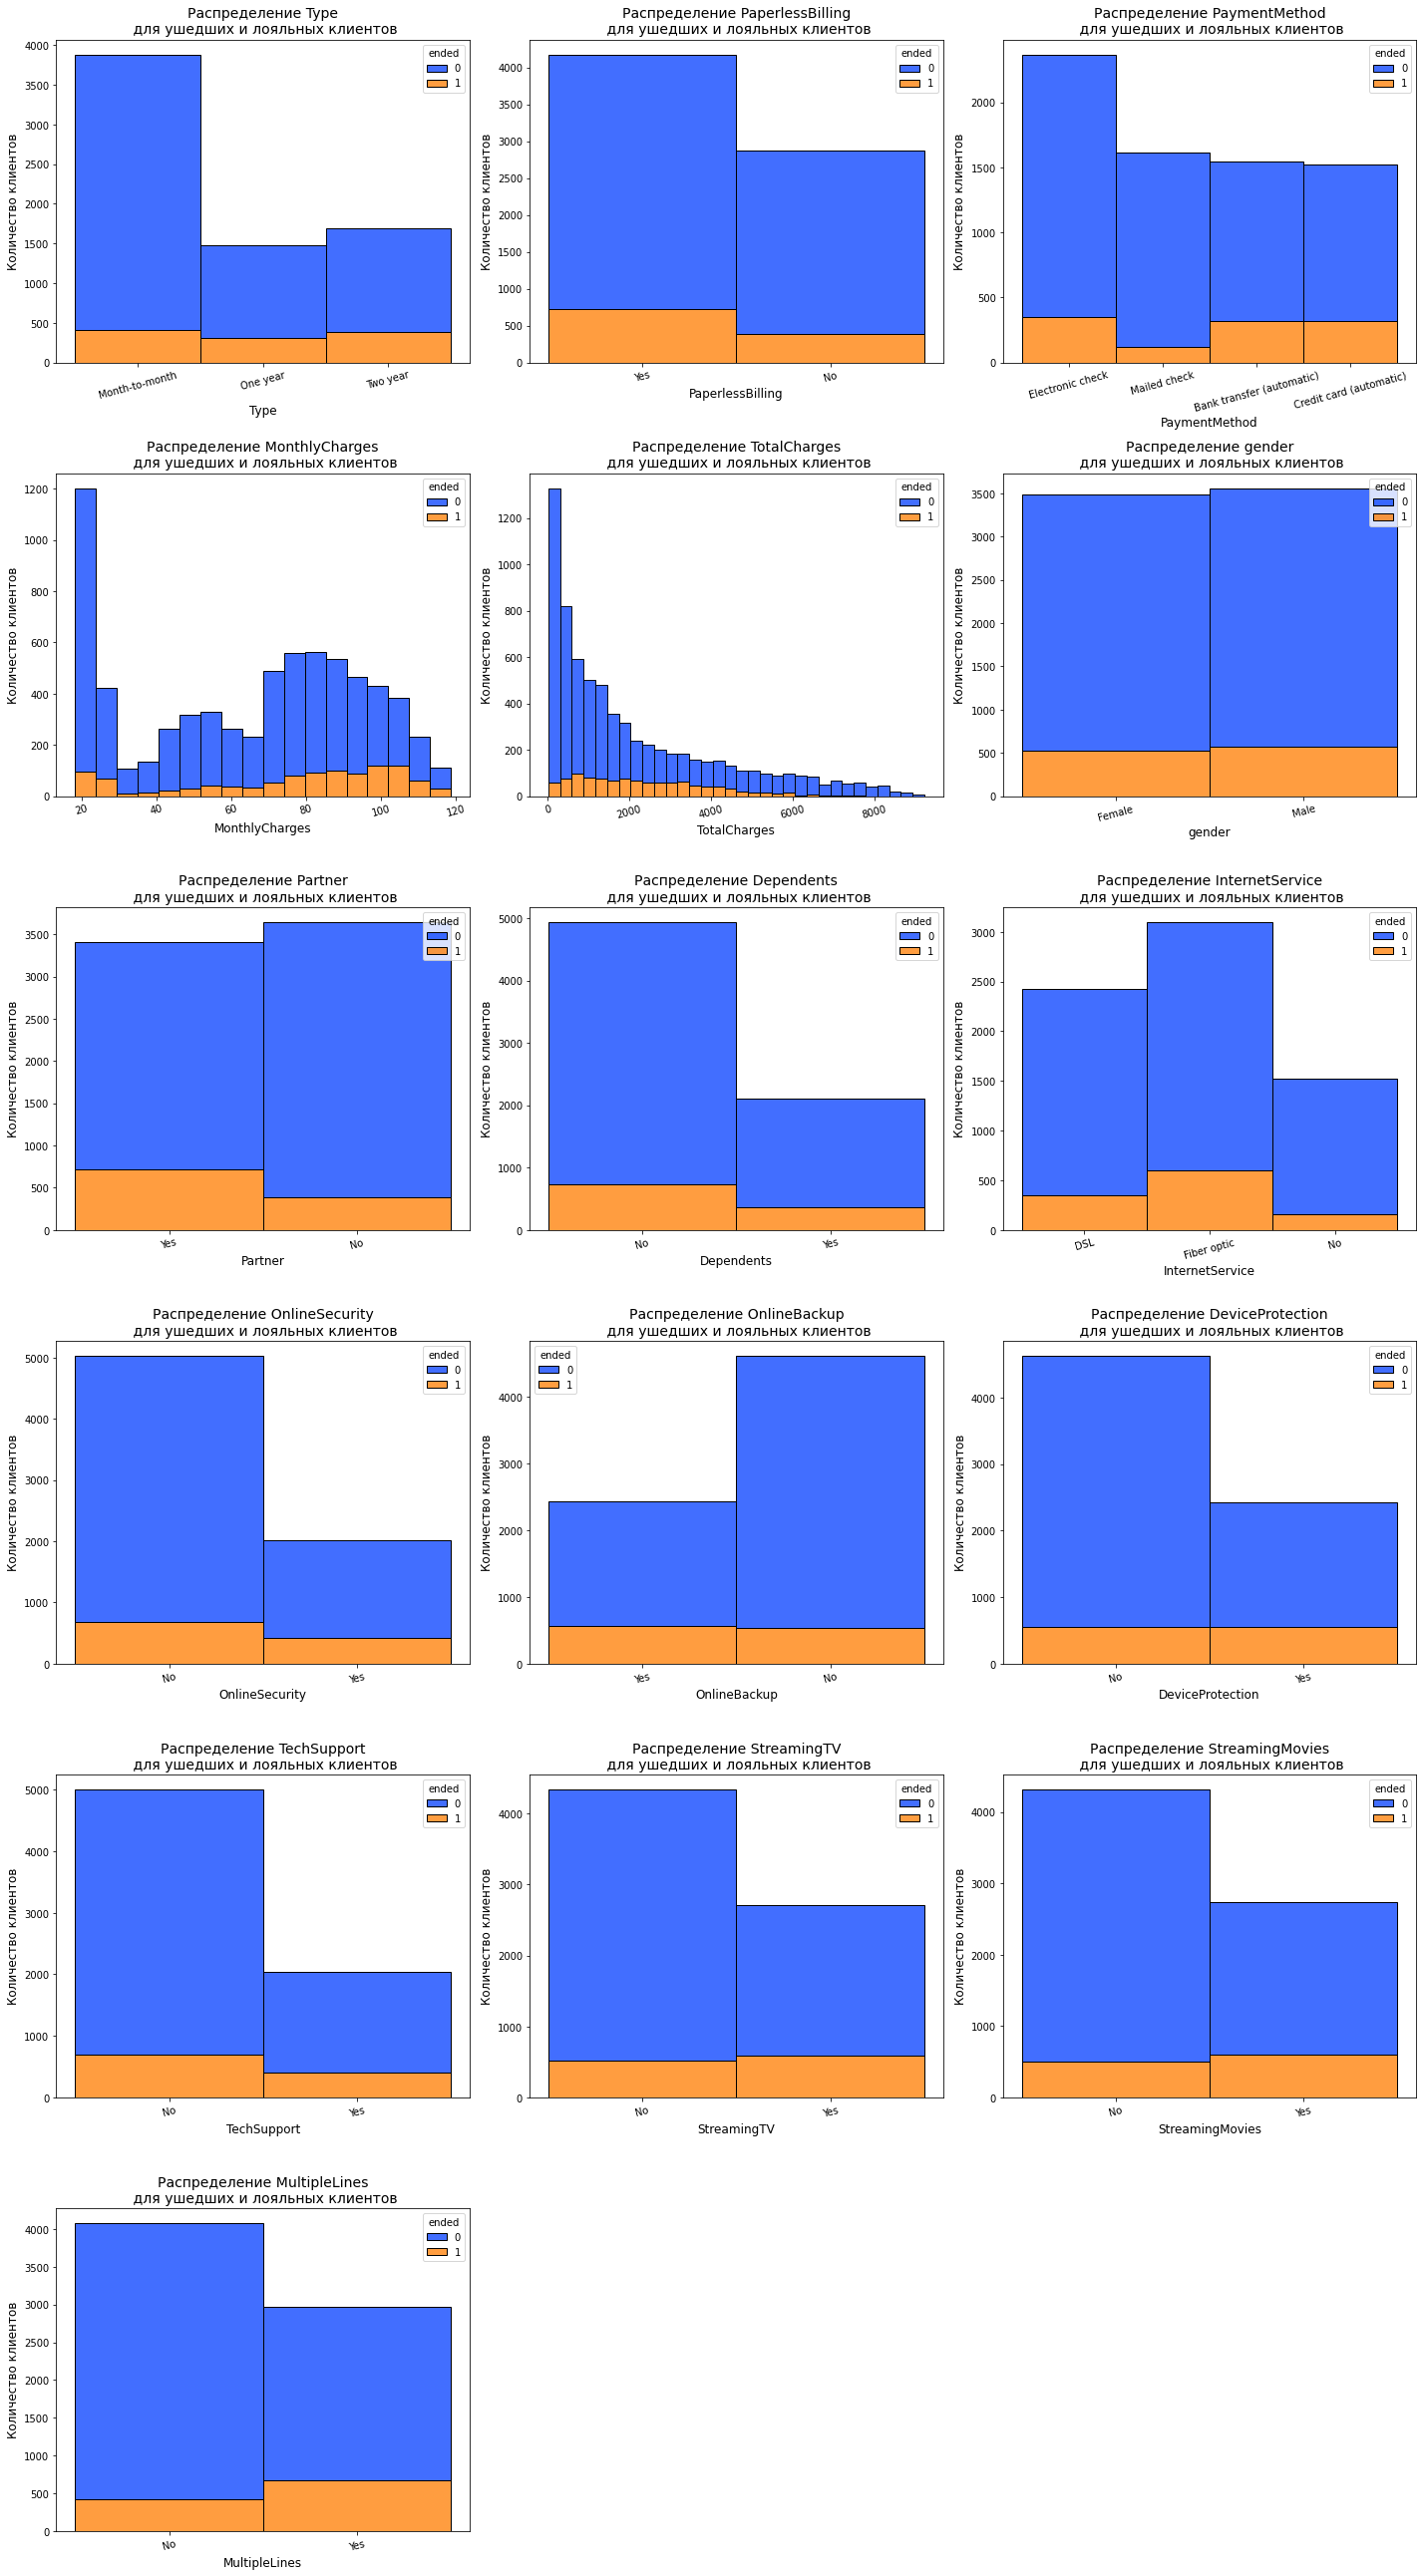

In [35]:
features_vis = df.drop(columns=['customerID', 'SeniorCitizen',
                                'BeginDate', 'EndDate', 'ended'])
features = features_vis.columns.tolist()

n_cols = 3
n_rows = int(np.ceil(len(features) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 6))

for i, feature in enumerate(features):
    row = i // n_cols 
    col = i % n_cols
    
    sns.histplot(data=df, x=feature, hue='ended', multiple='stack', palette='bright', ax=axes[row, col])
    
    axes[row, col].set_title(f'Распределение {feature}\n для ушедших и лояльных клиентов', fontsize=14)
    axes[row, col].set_xlabel(feature, fontsize=12)
    axes[row, col].set_ylabel('Количество клиентов', fontsize=12)
    axes[row, col].tick_params(axis='x', rotation=15)

for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

**Предварительные выводы по распределению признаков у ушедших vs. оставшихся клиентов:**
    
- Самое интересное - в распределении по оплатам за месяц. На более высоких значениях ежемесячных затрат (от 80 и выше) все чаще встречаются клиенты, разорвавшие договор. 

- Чаще уходят те клиенты, которые подключили телефон к нескольким линиям сразу (MultipleLines), не подключали выделенную поддержку (TechSupport) или блокировку опасных сайтов (OnlineSecurity), а также те, кто подключался к интернет по оптоволокну (InternetService). Возможно, это все случайные совпадения - или повод проверить качество этих услуг.

- Чем больше длится контракт, тем реже уходят клиенты. Пик приходится примерно на 1000 дней с момента заключения контракта. 

EndDate не будем отдельно снова визуализировать, тк он не поменялся с момента второго шага. Мы помним, что классы несбалансированы: тех, кто сохранил контракт, гораздо больше тех, кто его разорвал. Поэтому подойдет контрольная метрика ROC-AUC, она не так чувствительна к дисбалансу, как, скажем, accuracy, precision или recall. Проведем корреляционный анализ:

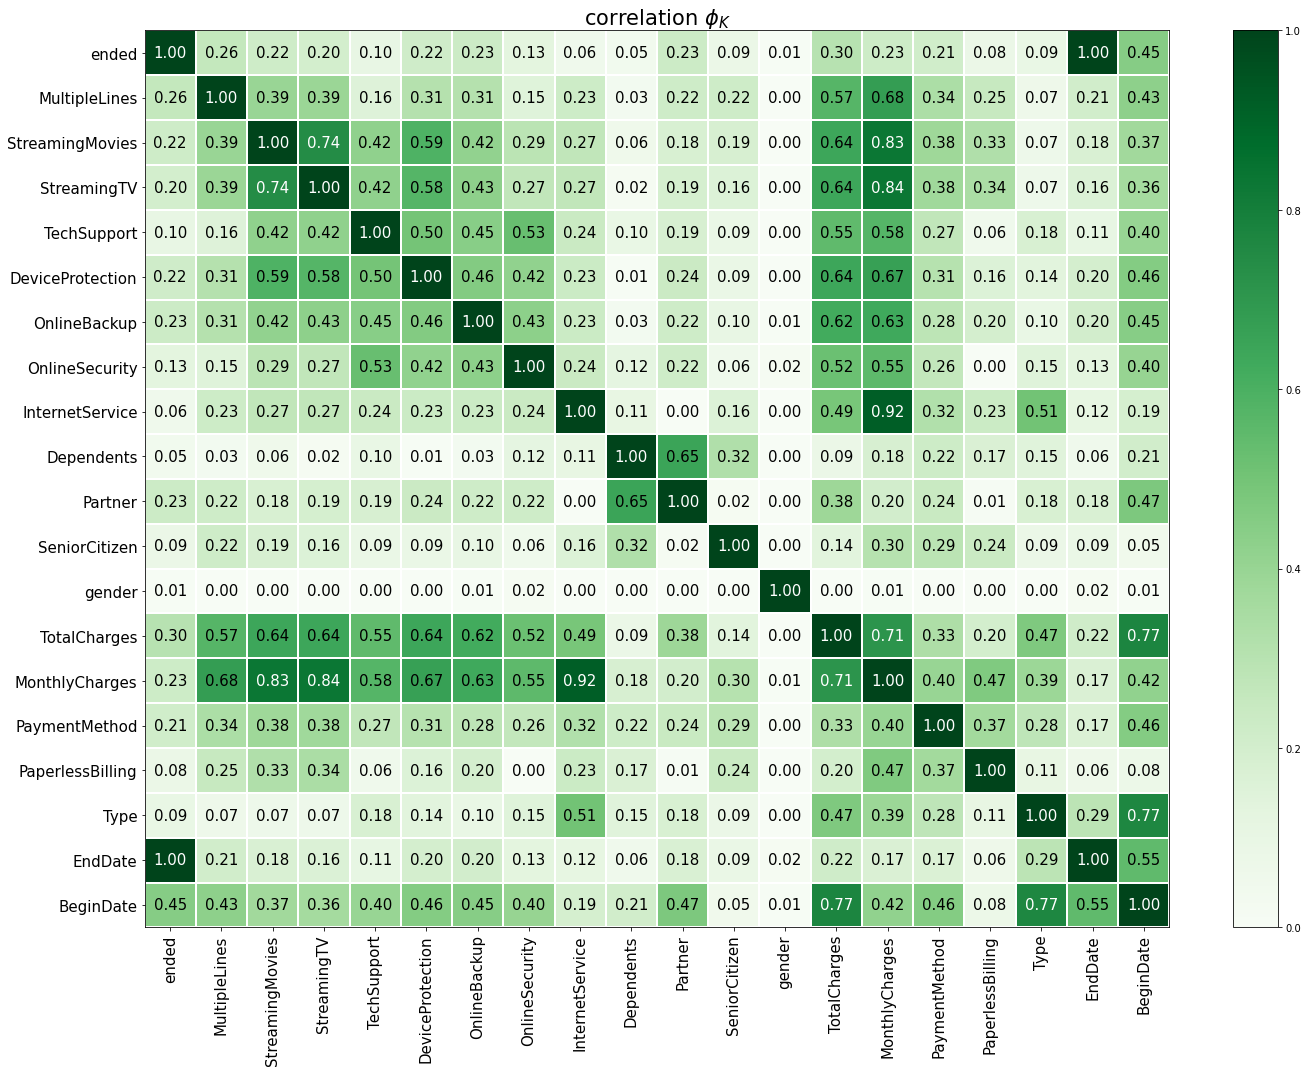

In [36]:
interval_cols = ['MonthlyCharges', 'TotalCharges']
phik_df = df.drop('customerID', axis=1)

phik_overview = phik_matrix(phik_df,interval_cols=interval_cols)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

**Предварительные выводы:**
    
- Пока с целевым признаком ended слабо коррелируют другие признаки, кроме BeginDate и EndDate, но оно и понятно: признак создали на основе EndDate.
- Есть мультиколлинеарность: MonthlyCharges и StreamingTV (0.84), MonthlyCharges и StreamingMovies, MonthlyCharges и InternetService. 
- StreamingTV, StreamingMovies, InternetService можно в целом и отбросить, они показывают очень малую связь с EndDate. Еще не особенно пригодятся в текущем виде TechSupport, OnlineSecurity, Dependents, Partner, SeniorCitizen, gender, MonthlyCharges, PaperlessBilling. Удалять пока все-таки не будем, пусть модель съест.

Подумаем над созданием новых признаков! Добавим длительность контракта для клиентов. Для тех, кто его не оборвал, EndDate проставим текущей датой, 1 февраля 2020 года.

In [37]:
df['BeginDate'] = pd.to_datetime(df['BeginDate'])

# Определение текущей даты
current_date = datetime(2020, 2, 1)

# Замена "No" на current_date в колонке EndDate
df['EndDate'] = df['EndDate'].apply(lambda x: current_date if x == 'No' else x)
df['EndDate'] = pd.to_datetime(df['EndDate'])

# Вычисление разницы между датами
df['Duration'] = df['EndDate'] - df['BeginDate']

# Преобразование разницы в дни
df['DurationDays'] = df['Duration'].dt.days.astype(int)

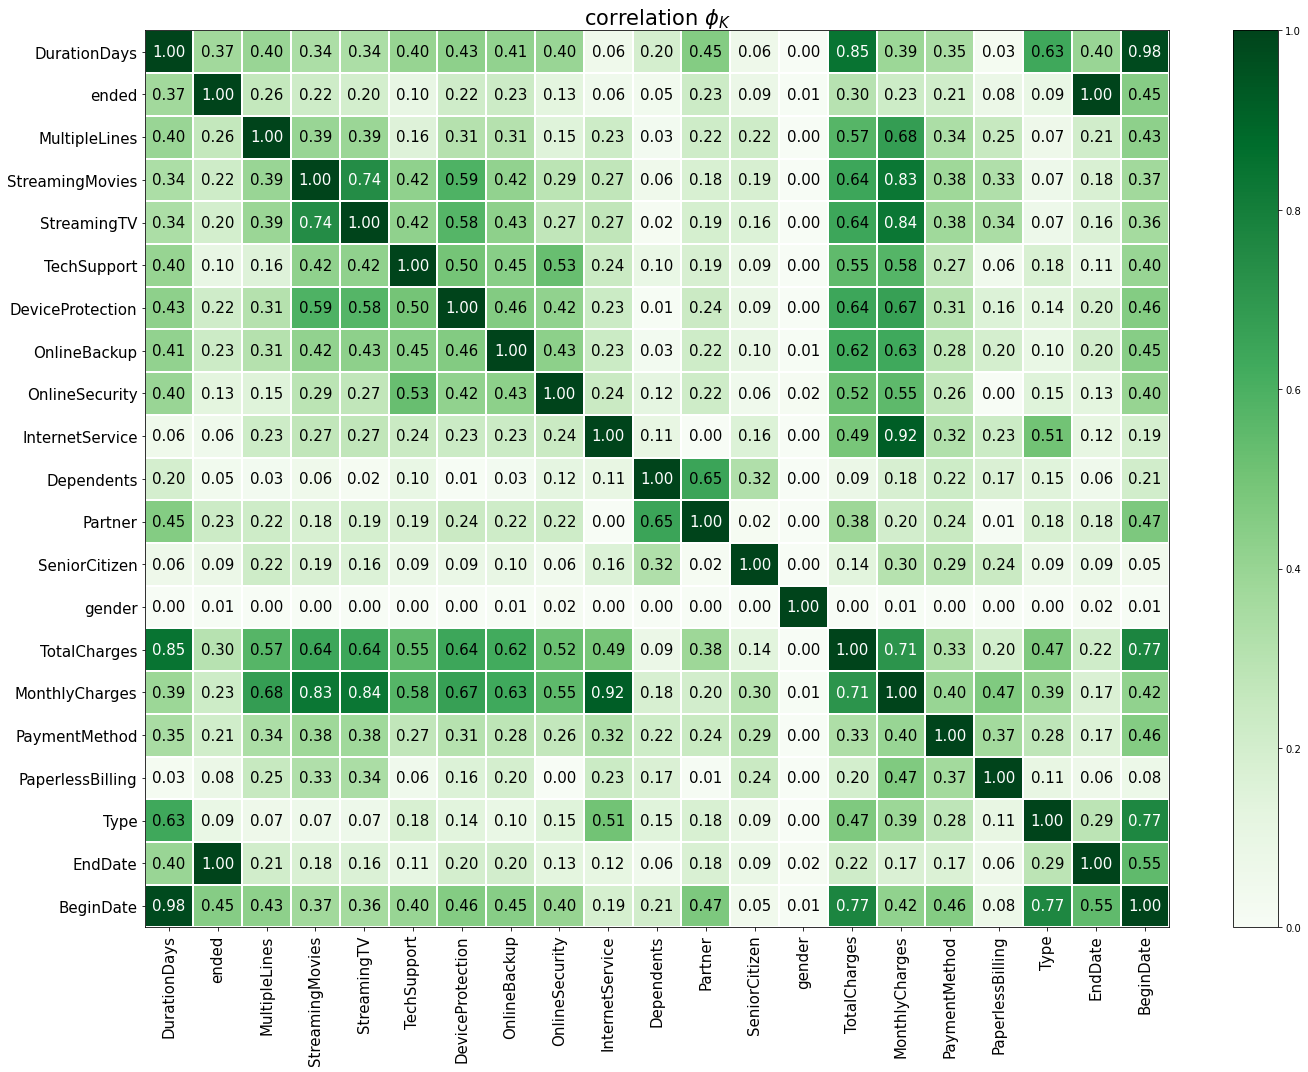

In [38]:
interval_cols = ['MonthlyCharges', 'TotalCharges', 'Year', 'DurationDays']
phik_df = df.drop(['customerID', 'Duration'], axis=1)

phik_overview = phik_matrix(phik_df,interval_cols=interval_cols)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

О, средняя корреляция есть у нового признака с целевым, оставляем! :)

## Выводы

- Объединили все четыре датафрейма с помощью ключа customerID методом merge(). На этом этапе сносить признаки пока не стали, как и после корреляционного анализа.


- Объединили сперва contract_df с personal_df с параметром how='inner'. Далее объединили общий датафрейм с internet_df и phone_df с параметром how='left'. Так мы сохранили все строчки из основных датафреймов. Там, где были пропуски, были NaN: их заменили пока на No. Далее закодируем.


- Непрерывные признаки особенно не изменились после объединения, тк они были для всех клиентов.


- Поменялись по распределению признаки, связанные с интернет-услугами и телефонией. Этого следовало ожидать, тк мы объединили датафреймы и появились клиенты, которые не пользуются или интернет-услугами, или телефонией.

- Создали целевой признак ended на основе EndDate.


- С целевым признаком ended слабо коррелируют другие признаки, кроме BeginDate и EndDate


- Есть мультиколлинеарность: MonthlyCharges и StreamingTV (0.84), MonthlyCharges и StreamingMovies, MonthlyCharges и InternetService. 


- StreamingTV, StreamingMovies, InternetService можно в целом и отбросить, они показывают очень малую связь с EndDate. Еще не особенно пригодятся в текущем виде TechSupport, OnlineSecurity, Dependents, Partner, SeniorCitizen, gender, MonthlyCharges, PaperlessBilling. Удалять пока все-таки не стали, пусть модель съест.


- Создали новый признак со средней корреляцией, длительность контракта в днях.

## Шаг 5. Подготовка данных

Сперва разобьем датасет на две выборки: тестовую и тренировочную. Валидационная здесь не понадобится, так как для промежуточной оценки будем использовать параметры из кросс-валидации.

При этом отбросим EndDate и BeginDate, тк это даты, они нагонят метрики, но с точки зрения бизнеса эффективности моделям не дадут. customerID тоже выкинем. Отбросим и часть признаков, которые, по phik-матрице, дадут мало смысла с точки зрения предсказаний.

Далее переведем признаки с вариантами Yes и No в булев тип.

In [39]:
fin_df = df.drop(['EndDate', 'StreamingTV', 'gender',
                  'OnlineSecurity', 'DeviceProtection',
                  'StreamingMovies', 'InternetService', 
                  'BeginDate', 'Dependents', 'customerID',
                 'SeniorCitizen', 'PaymentMethod'], axis=1)

y = fin_df['ended']
X = fin_df.drop(['ended'], axis=1)

binary_columns = ['Partner', 'PaperlessBilling', 'OnlineBackup', 
                  'TechSupport', 'MultipleLines']

for col in binary_columns:
    X[col] = X[col].map({'Yes': 1, 'No': 0})
    
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE)

print('Размерность X_train:', X_train.shape)
print('Размерность X_test:', X_test.shape)
print('Размерность y_train:', y_train.shape)
print('Размерность y_test:', y_test.shape)

Размерность X_train: (5282, 10)
Размерность X_test: (1761, 10)
Размерность y_train: (5282,)
Размерность y_test: (1761,)


Ага, все гуд с размерностью. Обработаку категориальных и числовых признаков для моделей, которым это понадобится, проведем в пайплайне при обучении моделей. Пока просто создадим num_features и cat_features.

In [40]:
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object']).columns.tolist()
cat_features = [col for col in cat_features if col not in binary_columns]

## Выводы

- Разбили датасет на две выборки: тестовую и тренировочную. Валидационная здесь не понадобится, так как для промежуточной оценки использовали параметры из кросс-валидации.


- Выбросили EndDate и BeginDate, тк это даты, они нагонят метрики, но с точки зрения бизнеса эффективности моделям не дадут. customerID тоже выкинули. Отбросили и часть признаков, которые, по phik-матрице, дадут мало смысла с точки зрения предсказаний.


- Перевели признаки с вариантами Yes и No в булев тип.


- Создали num)features и cat_features с числовыми и категориальными признаками соответственно для дальнейшей обработки в пайплайне.

## Шаг 6. Обучение моделей

В этом проекте будем использовать кросс-валидацию, а для поиска параметров - поиск по сетке GridSearchCV. В качестве метрик возьмем контрольную ROC AUC (условия проекта) и добавим к ней F1 AUC, чтобы балансировать точность предсказаний и верность определения, кто расторгнет контракт.

До обучения пропишем условия, одинаковые для всех моделей: число фолдов и метрики для оценки.

In [41]:
cv_counts = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

scoring = {
    'F1': make_scorer(f1_score),
    'ROC AUC': make_scorer(roc_auc_score, needs_proba=True)
}

In [42]:
warnings.filterwarnings('ignore', category=ConvergenceWarning)
class_weights = {0: 1, 1: 10}

base_pipeline = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(drop='first'), cat_features)
    ]
)

models = {
    'logistic_regression': LogisticRegression(max_iter=1000, 
                                              solver='saga', class_weight='balanced', n_jobs=-1),
    'random_forest': RandomForestClassifier(n_jobs=-1),
    'catboostclassifier': CatBoostClassifier(silent=True, class_weights=class_weights)
}

param_grids = {
    'logistic_regression': {
        'logisticregression__penalty': ['l2'],
        'logisticregression__C': [10, 20],
    },
    'random_forest': {
        'randomforestclassifier__n_estimators': [200, 500],
        'randomforestclassifier__max_depth': [30, 50],
        'randomforestclassifier__class_weight': ['balanced']
    },
    'catboostclassifier': {
        'catboostclassifier__depth': [3, 8],
        'catboostclassifier__iterations': [1600],
        'catboostclassifier__learning_rate': [0.1, 0.5],
        'catboostclassifier__l2_leaf_reg': [3, 9],
  }
}
scoring = {
    'roc_auc': 'roc_auc',
    'f1': make_scorer(f1_score)
}

best_models = {}

for model_name, model in tqdm(models.items(), desc='Статус по моделям'):
    pipeline = make_pipeline(base_pipeline, model)
    
    grid_search = GridSearchCV(
        pipeline,
        param_grids[model_name],
        scoring=scoring,
            cv=cv_counts,
        verbose=1,
        refit='roc_auc'
    )
    
    grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_
    
    print(f'\nЛучшие параметры для {model_name}:', grid_search.best_params_)
    print(f'Лучший ROC AUC на кросс-валидации для {model_name}:', round(grid_search.best_score_, 2))
    print(f'Лучший F1 Score на кросс-валидации для {model_name}:', round(grid_search.cv_results_['mean_test_f1'][grid_search.best_index_], 2))

Статус по моделям:   0%|                                  | 0/3 [00:00<?, ?it/s]

Fitting 5 folds for each of 2 candidates, totalling 10 fits


Статус по моделям:  33%|████████▋                 | 1/3 [00:00<00:01,  1.93it/s]


Лучшие параметры для logistic_regression: {'logisticregression__C': 20, 'logisticregression__penalty': 'l2'}
Лучший ROC AUC на кросс-валидации для logistic_regression: 0.76
Лучший F1 Score на кросс-валидации для logistic_regression: 0.4
Fitting 5 folds for each of 4 candidates, totalling 20 fits


Статус по моделям:  67%|█████████████████▎        | 2/3 [00:18<00:10, 10.89s/it]


Лучшие параметры для random_forest: {'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__max_depth': 30, 'randomforestclassifier__n_estimators': 500}
Лучший ROC AUC на кросс-валидации для random_forest: 0.82
Лучший F1 Score на кросс-валидации для random_forest: 0.38
Fitting 5 folds for each of 8 candidates, totalling 40 fits


Статус по моделям: 100%|██████████████████████████| 3/3 [02:49<00:00, 56.41s/it]


Лучшие параметры для catboostclassifier: {'catboostclassifier__depth': 3, 'catboostclassifier__iterations': 1600, 'catboostclassifier__l2_leaf_reg': 3, 'catboostclassifier__learning_rate': 0.1}
Лучший ROC AUC на кросс-валидации для catboostclassifier: 0.92
Лучший F1 Score на кросс-валидации для catboostclassifier: 0.65


Что можно сказать про лучшую модель CatBoostClassifier? Высокое значение ROC AUC показывает, что модель хорошо понимает разницу в классах (те, кто расторгнет контракт и сохранит его). При этом значение F1 Score показывает среднюю сбалансированность точности и полноты предсказаний.

Посмотрим на распределение ошибок:

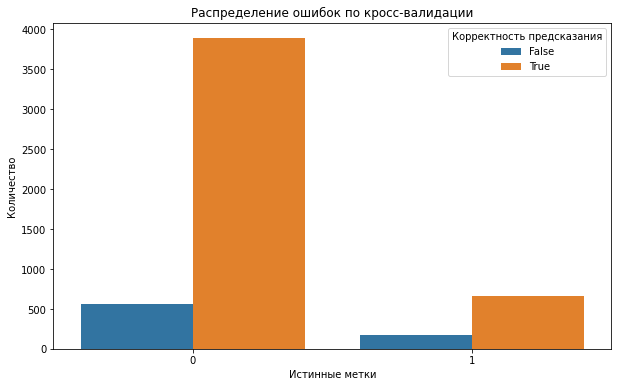

In [43]:
y_pred_cv = cross_val_predict(best_models['catboostclassifier'], X_train,
                              y_train, cv=cv_counts, method='predict')

errors_df_model = pd.DataFrame({
    'True': y_train,
    'Predicted': y_pred_cv,
    'Correct': y_train == y_pred_cv
})

plt.figure(figsize=(10, 6))
sns.countplot(x='True', hue='Correct', data=errors_df_model)
plt.title('Распределение ошибок по кросс-валидации')
plt.xlabel('Истинные метки')
plt.ylabel('Количество')
plt.legend(title='Корректность предсказания')
plt.show()

Видим, что модель довольно хорошо предсказывает негативные метки, то есть тех, кто может расторгнуть контракт: это для нас целевые предсказания. При этом довольно много ложноотрицательных ошибок.

## Выводы

- Использовали кросс-валидацию, а для поиска лучших параметров - поиск по сетке GridSearchCV. 


- В качестве промежуточных метрик по кросс-валидации взяли контрольную ROC AUC (условия проекта) и добавимлик ней F1 AUC, чтобы балансировать точность предсказаний и верность определения, кто расторгнет контракт.


- До обучения прописали условия, одинаковые для всех моделей: число фолдов и метрики для оценки.


- Обучили три модели: логистическую регрессию, RandomForestClassifier и CatBoostClassifier.


- Лучше всего сработала CatBoostClassifier с такими параметрами: глубина 3, число итераций 1600, коэффициент L2-регуляризации: 9, скорость обучения в 0.5


- Высокое значение ROC AUC показывает, что модель хорошо понимает разницу в классах (те, кто расторгнет контракт и сохранит его). При этом значение F1 Score показывает среднюю сбалансированность точности и полноты предсказаний.


- Визуализировали распределение ошибок. Модель довольно хорошо предсказывает негативные метки, то есть тех, кто может расторгнуть контракт: это для нас целевые предсказания. 

## Шаг 7. Выбор лучшей модели

Посмотрим на вероятность предсказания класса на тестовой выборке и на ROC AUC по ней для CatBoostClassifier:

In [44]:
probabilities_final = best_models['catboostclassifier'].predict_proba(X_test)[:, 1]
final_roc = roc_auc_score(y_test, probabilities_final)

predictions_final = (probabilities_final >= 0.5).astype(int)
final_f1 = f1_score(y_test, predictions_final)

print('Финальная ROC AUC для лучшей модели:', round(final_roc, 2))
print('Финальная F1 Score для лучшей модели:', round(final_f1, 2))

Финальная ROC AUC для лучшей модели: 0.9
Финальная F1 Score для лучшей модели: 0.62


Отлично, ROC AUC выше контрольного, проходим. Визуализируем кривую ROC AUC.

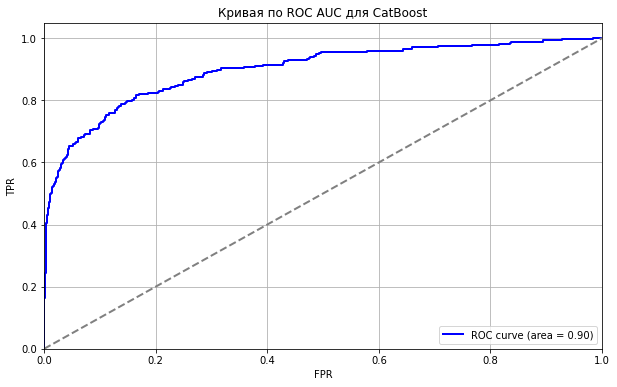

In [45]:
fpr, tpr, thresholds = roc_curve(y_test, probabilities_final)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {final_roc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Кривая по ROC AUC для CatBoost')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Что можно сказать? Хороший показатель площади под кривой, означающий, что модель не случайно угадывает классы. TPR довольно высокий пи низких значениях FPR, что тоже хороший знак.

Далее посмотрим, какие признаки вообще были значимыми:

In [46]:
best_catboost_model = best_models['catboostclassifier']
preprocessor = best_catboost_model.named_steps['columntransformer']

num_feature_names = preprocessor.transformers_[0][1].get_feature_names_out()
cat_feature_names = preprocessor.transformers_[1][1].get_feature_names_out()

feature_names = np.concatenate([num_feature_names, cat_feature_names])

importances = best_catboost_model.named_steps['catboostclassifier'].get_feature_importance()

importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

importances_df = importances_df.sort_values(by='Importance', ascending=False)
importances_df

,Feature,Importance
7,DurationDays,67.998014
1,MonthlyCharges,11.321896
2,TotalCharges,10.389367
9,Type_Two year,3.401888
3,Partner,1.711479
8,Type_One year,1.557144
4,OnlineBackup,1.172844
6,MultipleLines,1.147252
0,PaperlessBilling,0.682317
5,TechSupport,0.617798


Видим, что самый важный признак - длительность договора в днях. Далее - расходы на договор ежемесячно и суммарно за весь контракт.

Остальные признаки не особенно влияют на предсказания, особенно категориальные, описывающие детали каждого контракта.

## Шаг 7. Общий вывод и рекомендации заказчику

### Выводы:

**Загрузка:**

- Успешно загрузили четыре датафрейма;
- Изучили, какие признаки можно перевести в другой тип данных или оцифровать
- Явных дубликатов и пропусков пока не обнаружили


**Предобработка:**

- До анализа решили проблему с 11 пустыми строками в TotalCharges: заполнили их медианными значениями, тк строк не очень много

*contract_df:*

- EndDate: большая часть клиентов продлевает контракт (5942 строчки). Большинство клиентов из тех, кто не продлился, завершили контракт 2020-01-01: возможно, из-за годового повышения цен
- MonthlyCharges: ненормальное распределение со сдвигом влево, аномалий скорее всего нет. Большинство клиентов платит от 40 до 90 в месяц.
- TotalCharges: ненормальное распределение со сдвигом влево, довольно большой разброс по тратам. Аномалий как таковых нет: можно допустить, что клиенты с долгой историей заплатили суммарно более 7000.
- Половина клиентов из набора ежемесячно оплачивает договор
- Большинство предпочитает электронный расчетный лист
- По методу оплат лидирует электронный чек.

*personal_df:*

- Людей старшего возраста среди клиентов гораздо меньше, чем других возрастных категорий
- По полу клиентов примерно поровну
- Клиентов c супругом(-ой) и без них (нее) тоже поровну
- Клиентов без детей больше, чем с детьми: 70% против 30%.

*internet_df:*

- Немного больше клиентов выбирают оптоволокно, не DSL: 56.1%
- Услуги по блокировке опасных сайтов оформляют чуть больше трети клиентов (36.6%)
- Облачное хранилище оформляют 44% клиентов
- Антивирус устанавливают примерно столько же, 43.9%
- Выделенную поддержку берут 37% клиентов
- Стриминговое ТВ и каталог фильмов оформляют примерно по половине клиентов.

*phone_df:*

- Подключение телефона к нескольким линиям одновременно оформляют 46.7% клиентов

По поводу признаков, которые могут нам понадобиться для модели:
- Предварительно кажется, что пригодиться могут затраты на договор. Есть сомнения по деталям договора и доп услугам.

**Объединение данных и исследовательский анализ:**

- Объединили все четыре датафрейма с помощью ключа customerID методом merge(). На этом этапе сносить признаки пока не стали, как и после корреляционного анализа.

- Объединили сперва contract_df с personal_df с параметром how='inner'. Далее объединили общий датафрейм с internet_df и phone_df с параметром how='left'. Так мы сохранили все строчки из основных датафреймов. Там, где были пропуски, были NaN: их заменили пока на No. Далее закодируем.

- Непрерывные признаки особенно не изменились после объединения, тк они были для всех клиентов.

- Поменялись по распределению признаки, связанные с интернет-услугами и телефонией. Этого следовало ожидать, тк мы объединили датафреймы и появились клиенты, которые не пользуются или интернет-услугами, или телефонией.

- Создали целевой признак ended на основе EndDate.

- С целевым признаком ended слабо коррелируют другие признаки, кроме BeginDate и EndDate

- Есть мультиколлинеарность: MonthlyCharges и StreamingTV (0.84), MonthlyCharges и StreamingMovies, MonthlyCharges и InternetService. 

- StreamingTV, StreamingMovies, InternetService можно в целом и отбросить, они показывают очень малую связь с EndDate. Еще не особенно пригодятся в текущем виде TechSupport, OnlineSecurity, Dependents, Partner, SeniorCitizen, gender, MonthlyCharges, PaperlessBilling. Удалять пока все-таки не стали, пусть модель съест.

- Создали новый признак со средней корреляцией, длительность контракта в днях.

**Подготовка данных:**
- Разбили датасет на две выборки: тестовую и тренировочную. Валидационная здесь не понадобится, так как для промежуточной оценки использовали параметры из кросс-валидации.
- Выбросили EndDate и BeginDate, тк это даты, они нагонят метрики, но с точки зрения бизнеса эффективности моделям не дадут. customerID тоже выкинули. Отбросили и часть признаков, которые, по phik-матрице, дадут мало смысла с точки зрения предсказаний.
- Перевели признаки с вариантами Yes и No в булев тип.
- Создали num)features и cat_features с числовыми и категориальными признаками соответственно для дальнейшей обработки в пайплайне.

**Обучение моделей:**
    
- В качестве промежуточных метрик по кросс-валидации взяли контрольную ROC AUC (условия проекта) и добавимлик ней F1 AUC, чтобы балансировать точность предсказаний и верность определения, кто расторгнет контракт.
- Обучили три модели: логистическую регрессию, RandomForestClassifier и CatBoostClassifier.
- Лучше всего сработала CatBoostClassifier с такими параметрами: глубина 3, число итераций 1600, коэффициент L2-регуляризации: 9, скорость обучения в 0.5
- Высокое значение ROC AUC показывает, что модель хорошо понимает разницу в классах (те, кто расторгнет контракт и сохранит его). При этом значение F1 Score показывает среднюю сбалансированность точности и полноты предсказаний.
- Визуализировали распределение ошибок. Модель довольно хорошо предсказывает негативные метки, то есть тех, кто может расторгнуть контракт: это для нас целевые предсказания. 

**Выбор лучшей модели:**
    
- Отлично, ROC AUC выше контрольного, прошли. 
- Визуализировали кривую ROC AUC. Хороший показатель площади под кривой, означающий, что модель не случайно угадывает классы. TPR довольно высокий пи низких значениях FPR, что тоже хороший знак.
- Самый важный признак - длительность договора в днях. Далее - расходы на договор ежемесячно и суммарно за весь контракт.

### Рекомендации заказчику:

- Думаю, что перед запуском промокодов и других акций надо посчитать, сколько в целом мы теряем денег от ухода клиента. Это поможет понять, сойдется ли экономика и какой бюджет можно выделить на промо.
- Данные, которые сейчас дает заказчик для МЛ, неоптимальны: многие признаки нерелевантны, есть проблема с типами данных. Еще стоит ввести новую сущность - длительность контракта в днях, так как признак важен.
- Еще один источник потенциально полезных данных - форма опроса для клиентов, которые хотят расторгнуть контракт. Так можем узнать причины ухода и, возможно, разработать более эффективную маркетинговую кампанию.
- Большинство клиентов из тех, кто не продлился, завершили контракт 2020-01-01: возможно, из-за годового повышения цен. Можно пристальнее изучить этот период и потенциальные причина пика по расторжению контракта.